# Problem Set 7, due December 3 at 11:59pm

<span style="color:red">WARNING:</span> Some of the problems in this problem set require heavy computation - you are encouraged to start early so that you don't get stuck at the last minute.

# Face Recognition

Your goal for this problem set is to design a basic face recognition system. Since the machine learning force is now strong with you, the prompts for this problem set are deliberately vague. Be creative - but be careful!

One suggestion: Start by implementing this entire problem set on a relatively small subset of all of the images first, before using the full dataset.

## 1. Data Exploration

Download the "[Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)" data set from [this link](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (roughly 250MB).

### 1.1. Filter out people with few images

Display a histogram that shows the number of images per individual (you may use log-scale if you like). Which individual has the most images? Throw away all people for whom you have fewer than 10 images.

> <font color='red'>Modules:</font>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from tqdm import tqdm_notebook

> <font color='red'>Create a dataframe which holds names and number of images:</font>

In [2]:
# get the names
image_root = './lfw_funneled'
names = [item for item in os.listdir(image_root) if os.path.isdir(os.path.join(image_root, item))]

# get the number of images
n_images = np.zeros(len(names))
for i in range(len(names)):
    DIR = image_root + '/' + names[i]
    n_images[i] = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
    
# create the dataframe
image_df = pd.DataFrame({'name':names, 'n':n_images})
image_df.sort_values('name', inplace=True)
image_df.reset_index(drop=True, inplace=True)

> <font color='red'>Histogram:</font>

George_W_Bush has the most images, with 530.0 images.


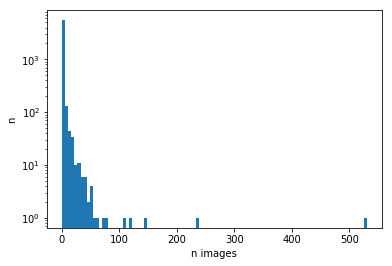

In [3]:
max_ind = image_df['n'].idxmax()
print(image_df['name'][max_ind] + ' has the most images, with ' + str(image_df['n'][max_ind]) + ' images.')

fig, ax = plt.subplots()

ax.hist(image_df['n'], bins=100, log=True)
ax.set_xlabel('n images')
ax.set_ylabel('n')

plt.show(fig)

> <font color='red'>Get rid of people with fewer than 10 images:</font>

In [4]:
image_df = image_df[image_df['n']>=10]
image_df.reset_index(drop=True, inplace=True)
print('number of remaining people = {}'.format(len(image_df.index)))
print('number of remaining images = {}'.format(np.sum(image_df['n'])))

number of remaining people = 158
number of remaining images = 4324.0


### 1.2. Show some faces!

1. Pick 8 random images from the dataset and display them in a 2 x 4 grid.
2. Create a single image that shows the "average face" -- i.e., each pixel should display the average value of that pixel across all of the images. 
3. For each pixel, calculate the standard deviation of values for that pixel (you will have a different standard deviation for each of the three color channels, feel free to just show the standard deviation of one of the channels, or to average the standard deviation of the three channels at each pixel). Plot these standard deviations as a heatmap.

What do you notice about the distribution of mean and standard deviation values in these images? (e.g., are they evenly distributed)

> <font color='red'>Individuals:</font>

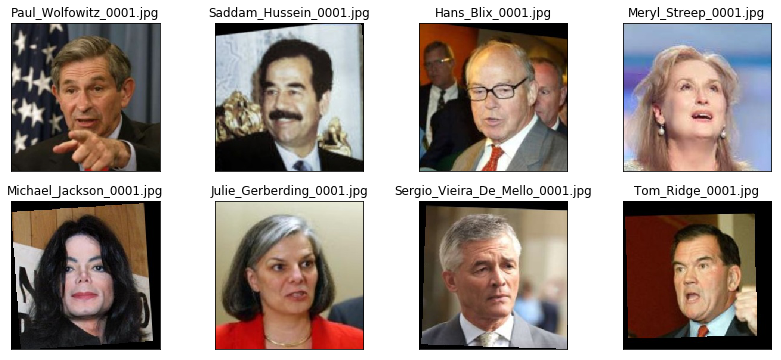

In [5]:
# pick 8 random people
np.random.seed(22)
random_8 = np.random.choice(image_df['name'], 8)

# plot them individually
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(14,6))

ax = ax.flatten()

for i in range(len(random_8)):
    img = mpimg.imread(image_root+'/'+random_8[i]+'/'+random_8[i]+'_0001.jpg')
    ax[i].imshow(img)
    ax[i].set_title(random_8[i]+'_0001.jpg')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show()

> <font color='red'>Average face:</font>

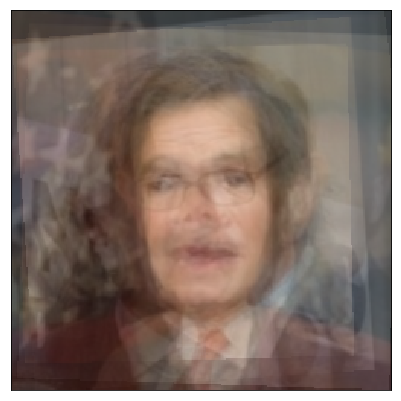

In [6]:
# get all the arrays for the 8 faces
face_arrays = []
for i in range(len(random_8)):
    img = mpimg.imread(image_root+'/'+random_8[i]+'/'+random_8[i]+'_0001.jpg')
    face_arrays.append(img)

# compute the average face (divide by 255 because imshow requires floats to be between 0 and 1)
avg_face = np.mean(face_arrays, axis=0)
avg_face = avg_face/255

# plot
fig, ax = plt.subplots(figsize=(7,7))

ax.imshow(avg_face)
ax.set_xticks([])
ax.set_yticks([])

plt.show(fig)

> <font color='red'>Standard deviation:</font>

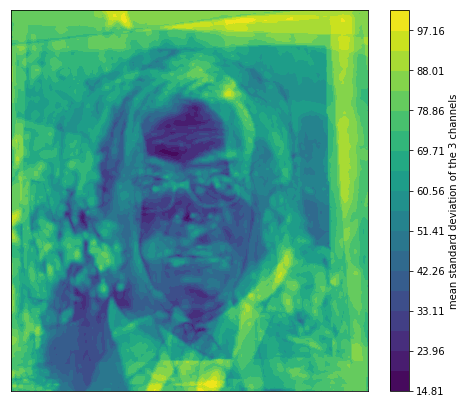

In [7]:
# standard deviation
avg_face_std = np.std(face_arrays, axis=0)

# average the three channels
avg_face_std = np.mean(avg_face_std, axis=2)

# plot
fig, ax = plt.subplots(figsize=(8,7))

levels = np.linspace(np.min(avg_face_std),np.max(avg_face_std), 20)
cntrf = ax.contourf(np.arange(np.shape(avg_face_std)[0]),
                    np.arange(np.shape(avg_face_std)[1]),
                    avg_face_std,
                    cmap='viridis', levels=levels)
cbar = fig.colorbar(cntrf, ax=ax)
cbar.ax.set_ylabel('mean standard deviation of the 3 channels')
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])

plt.show(fig)

> <font color='red'>As we can see, the faces are all approximately centered and upright. Therefore, given that the skin tones of the 8 randomly selected people are approximately the same, we notice that the center of the average face image has a relatively low standard deviation. However, the backdrop for all of the faces are highly varied, and therefore we observe a much higher standard deviation around the edges of the average face image. Furthermore, in the average face image, we can roughly identify that there is a vague face in the center of the image, but it is difficult to identify anything in particular in the backdrop around the edges, for the reasons described above.</font>

## 2. k-Means Clustering


### 2.1. Implementation

Implement the k-Means clustering algorithm that we discussed in class, using the Euclidean distance function. This will require that you define three new functions:
1. InitializeCentroids(X, k)
2. FindClosestCentroids(X, centroids)
3. ComputeCentroidMeans(X, centroids, k)

*Hint:* You may find  the [`pairwise_distances_argmin`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html) function useful.

> <font color='red'>Now the functions:</font>

In [8]:
# import helpful module
from sklearn.metrics import pairwise_distances_argmin

### InitializeCentroids
def InitializeCentroids(X, k, seed=22):
    """
    Initialize centroids for k-Means clustering.
    
    Parameters
    ----------
    X : numpy array
        Data.
    
    k : int
        Number of centroids.
        
    seed : int
        Seed for numpy random number generator.
        
    Returns
    -------
    centroids : numpy array
        Coordinates of the centroids.
    """
    # just randomly pick k of the data rows to be the initial centroids
    np.random.seed(seed)
    rows = np.random.choice(np.shape(X)[0], k, replace=False)
    centroids = X[rows].copy()
    
    return centroids

### FindClosestCentroids
def FindClosestCentroids(X, centroids):
    """
    Find closest centroids for k-Means clustering.
    
    Parameters
    ----------
    X : numpy array
        Data.
    
    centroids : numpy array
        Coordinates of the centroids.
        
    Returns
    -------
    idx : numpy array
        Assigned centroids (cluster) for the data.
    """
    # yay for built-in functions
    idx = pairwise_distances_argmin(X, centroids, metric='euclidean')
    
    return idx

### ComputeCentroidMeans
def ComputeCentroidMeans(X, centroids, idx, k):
    """
    Compute centroid means for k-Means clustering.
    
    Parameters
    ----------
    X : numpy array
        Data.
        
    centroids : numpy array
        Coordinates of the centroids.
    
    idx : numpy array
        Assigned centroids (cluster) for the data.
        
    k : int
        Number of centroids.
        
    Returns
    -------
    new_centroids : numpy array
        Coordinates of the updated centroids.
    """
    # initialize new centroids
    new_centroids = np.zeros(np.shape(centroids))
    
    # iterate through each cluster
    for i in range(k):
        
        # pull out points in that cluster
        this_X = X[idx==i]
        
        # compute the mean
        new_centroid = np.mean(this_X, axis=0)
        
        # store
        new_centroids[i] = new_centroid
        
    return new_centroids

### ClusterKM
def ClusterKM(X, k):
    """
    k-Means clustering.
    
    Parameters
    ----------
    X : numpy array
        Data.
        
    k : int
        Number of centroids.
        
    Returns
    -------
    centroids : numpy array
        Coordinates of the centroids.
        
    idx : numpy array
        Assigned centroids (cluster) for the data.
    """
    # randomly choose clusters
    centroids = InitializeCentroids(X, k)
    
    # keep looping until convergence
    while True:
        
        # assign labels based on closest center
        idx = FindClosestCentroids(X, centroids)
        new_centroids = ComputeCentroidMeans(X, centroids, idx, k)

        # check for convergence
        if np.all(centroids == new_centroids):
            break
        else:
            centroids = new_centroids
    
    return centroids, idx

### 2.2. Sanity check

Apply your k-Means algorithm to a toy dataset to make sure it works properly. 

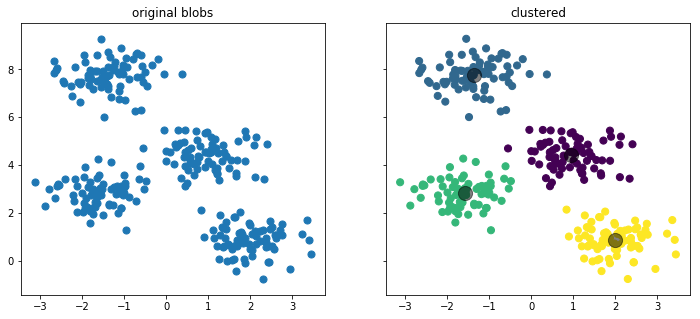

In [9]:
# import necessary module
from sklearn.datasets.samples_generator import make_blobs

# make blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

# cluster
myCenters, myIdx = ClusterKM(X, 4)

# plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,5))

ax[0].scatter(X[:, 0], X[:, 1], s=50)
ax[0].set_title('original blobs')

ax[1].scatter(X[:, 0], X[:, 1], c=myIdx, s=50, cmap='viridis')
ax[1].scatter(myCenters[:, 0], myCenters[:, 1], c='black', s=200, alpha=0.5)
ax[1].set_title('clustered')

plt.show(fig)

> <font color='red'>Looks to be working fine...</font>

### 2.3. Image centroids
Apply your k-Means algorithm to the images dataset, using k=20. Make sure to normalize your data first! Show a 20 x 2 grid of images where the first column contains (a) the image that represents the centroid for each of those clusters, and the second column contains (b) the closest image in the original dataset to that centroid. Use Euclidean distance. What do you notice?

*Note:* As you may notice, there are 250$\times$250$\times$3 = 187500 features for each image. If your k-Means algorithm is not implemented efficiently -- an even if it is! -- it might take a long time for your algorithm to converge. If your computer is old, it might even take a very long time for you to simply normalize your data. If you are running into such problems, you may convert your RGB images into greyscale first (using, for instance, the [`rgb2grey`](http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey) function).



> <font color='red'>Begin by creating the dataset `X`:</font>

In [10]:
# initialize the array
X = np.zeros((int(np.sum(image_df['n'])), 250*250*3))

# row counter
row = 0

# iterate through the names
for i in range(len(image_df.index)):
    
    # iterate through the images for that person
    for j in range(int(image_df['n'][i])):
        
        # get necessary strings (formatted correctly)
        name_str = image_df['name'][i]
        n_str = str(j+1).zfill(4)
        
        # get the image
        img = mpimg.imread(image_root+'/'+name_str+'/'+name_str+'_'+n_str+'.jpg')
        
        # divide by 255, then normalize
        img = img/255
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        
        # reshape it
        img = img.reshape(250*250*3)
        
        # store it
        X[row] = img
        
        # tick the row
        row = row + 1

> <font color='red'>Cluster (save the output as .txt files, so we don't have to recompute every time we close the notebook):</font>

In [11]:
refresh = False

if refresh:
    centroids, idx = ClusterKM(X, 20)
    np.savetxt('centroids.txt',centroids)
    np.savetxt('idx.txt',idx)
else:
    centroids = np.loadtxt('centroids.txt')
    idx = np.loadtxt('idx.txt')

> <font color='red'>Plot the centroids, with the closest neighbour:</font>

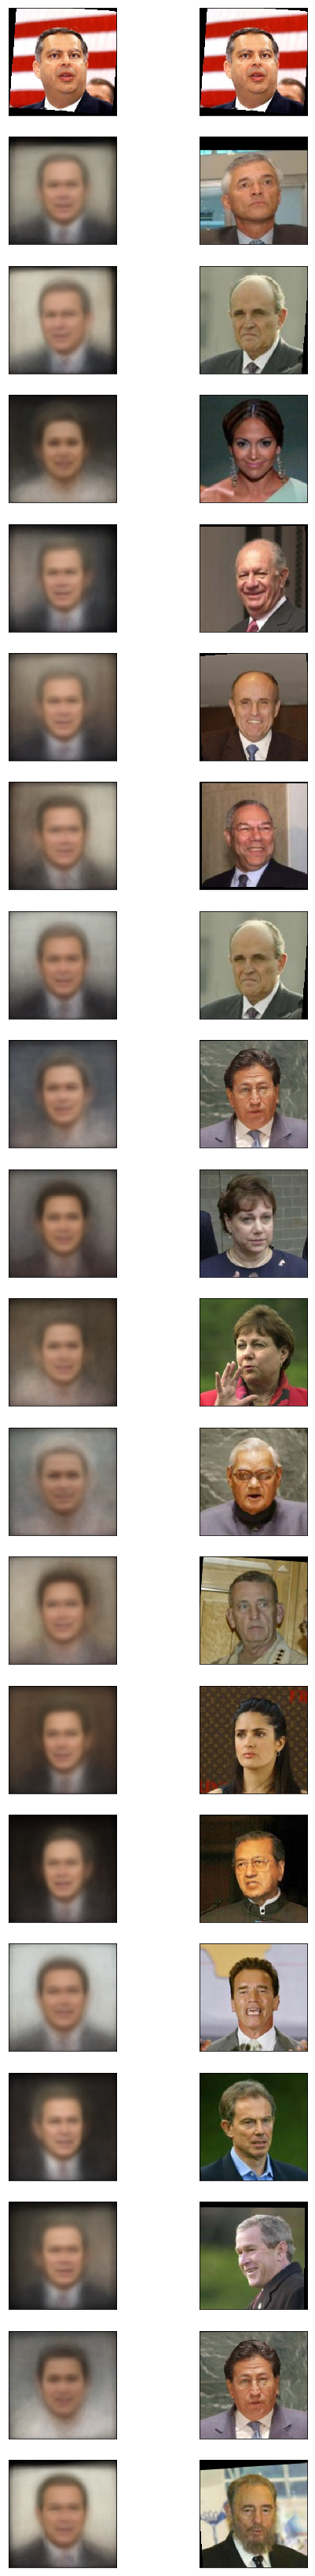

In [12]:
# find the closest neighbours
closest_neighbours = pairwise_distances_argmin(centroids, X, metric='euclidean')

# plot
fig, ax = plt.subplots(nrows=20, ncols=2, figsize=(8,60))

for i in range(20):
    ax[i][0].imshow(centroids[i].reshape(250, 250, 3))
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    
    ax[i][1].imshow(X[closest_neighbours[i]].reshape(250,250,3))
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    
plt.show(fig)

> <font color='red'>In general, the centroid images all appear to display a vague, generic white male wearing a suit and tie. However, the shade of the background is noticably different between each centroid image. Furthermore, when we compare the centroid image to its nearest neighbour, we notice that the background matches well with the background of the centroid image (including black borders resulting from cropping/rotating the image to center the face), but the actual face need not.
>
> This clearly illustrates that the current implementation of k-Means clustering is more sensitive to the background of the image, rather than face itself. Intuitively, this makes sense, because human faces are much more similar to one another than backgrounds are (e.g. we all have eyes, noses, mouths, etc, and our complexions are generally limited to a small range). Therefore, when trying to cluster the images, the method picks up on the greatest differences between the images (as it is supposed to), and this happens to be the backgrounds.</font>

### 2.4 Classify yourself

Take a picture of yourself and scale it so that it is in a similar format to the images in the dataset. Show four images:
 1. The image of yourself
 2. The cluster centroid closest to that image
 3. The closest image in the original dataset to that cluster centroid
 4. The closest image in the original dataset to the image of yourself


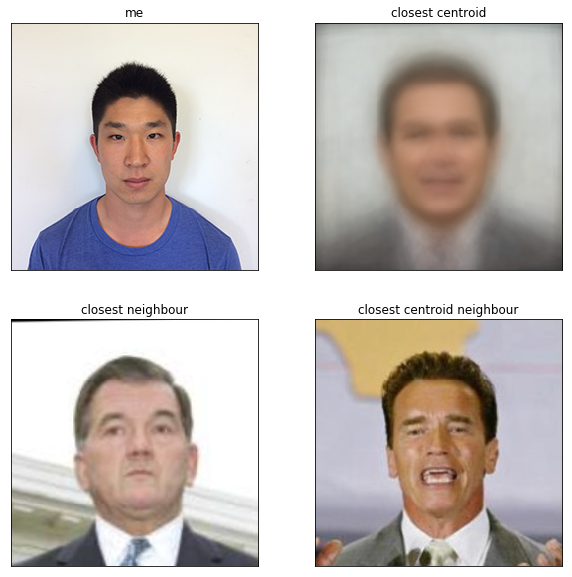

In [13]:
# read myself in, reshaping
me = mpimg.imread('me.jpg')
me = me.reshape((1, 250*250*3))

# closest centroid
me_closest_centroid = pairwise_distances_argmin(me, centroids, metric='euclidean')

# closest image
me_closest_neighbour = pairwise_distances_argmin(me, X, metric='euclidean')

# plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()

ax[0].imshow(me.reshape(250,250,3))
ax[0].set_title('me')

ax[1].imshow(centroids[me_closest_centroid[0]].reshape(250,250,3))
ax[1].set_title('closest centroid')

ax[2].imshow(X[me_closest_neighbour[0]].reshape(250,250,3))
ax[2].set_title('closest neighbour')

ax[3].imshow(X[closest_neighbours[me_closest_centroid[0]]].reshape(250,250,3))
ax[3].set_title('closest centroid neighbour')

for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show(fig)

> <font color='red'>Same issues as described in part 2.3 can be seen here: the clustering method is more sensitive to the background than the face itself, so the closest centroid/image is that which has a very light background, like my image.</font>

## 3. PCA and Eigenfaces 

Begin by normalizing your data. Then, set aside 50% of the images as "test" data and using the remaining images as "training" data.


### 3.1. How many components?

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn on the training dataset. Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 100. How many components are required to explain 75% of the variation in your original data?

> <font color='red'>Split into training and testing (data has already been normalized above):</font>

In [14]:
# get the training inds
np.random.seed(22)
train_inds = np.random.choice(np.shape(X)[0], int(np.shape(X)[0]/2), replace=False)
train_inds = np.sort(train_inds)

# get the testing inds
test_inds = np.array([], dtype=int)
for i in range(np.shape(X)[0]):
    if i not in train_inds:
        test_inds = np.append(test_inds, i)
        
# get the respective arrays
X_train = X[train_inds].copy()
X_test = X[test_inds].copy()

> <font color='red'>PCA:</font>

In [15]:
# import module
from sklearn.decomposition import PCA
    
# PCA
pca = PCA(n_components=100)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

we pass 75% of the variance in the data with:
47 components
when we explain 75.16% of the variance


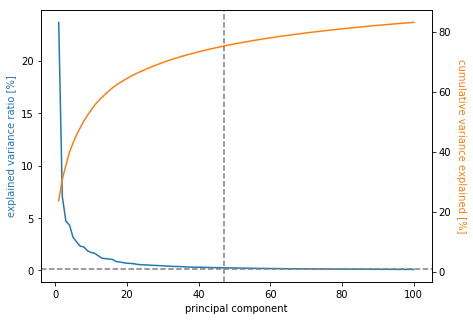

In [16]:
# when do we cross 75%?
ind_75 = np.argmax((np.cumsum(pca.explained_variance_ratio_)*100)>75)
print('we pass 75% of the variance in the data with:')
print('{} components'.format(ind_75+1))
print('when we explain {:.2f}% of the variance'.format(np.cumsum(pca.explained_variance_ratio_)[ind_75]*100))

# plot
fig, ax = plt.subplots(figsize=(7,5))

rects = ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_*100, color='C0')
ax.set_ylabel('explained variance ratio [%]', color='C0')
ax.set_xlabel('principal component')

twinax = ax.twinx()
twinax.plot(np.arange(len(pca.explained_variance_ratio_))+1,
            np.cumsum(pca.explained_variance_ratio_)*100, color='C1')
twinax.axhline(np.cumsum(pca.explained_variance_ratio_)[ind_75], ls='--', c='C7')
twinax.axvline(ind_75+1, ls='--', c='C7')
twinax.set_ylabel('cumulative variance explained [%]', rotation=270, color='C1', labelpad=15)

plt.show(fig)

> <font color='red'>By considering more and more principal components, we can explain more and more of the variance in the data, but each additional component is able to explain less and less on its own.</font>

### 3.2. Eigenfaces

Extract the 10 first principal components (the "eigenfaces") and display them below.

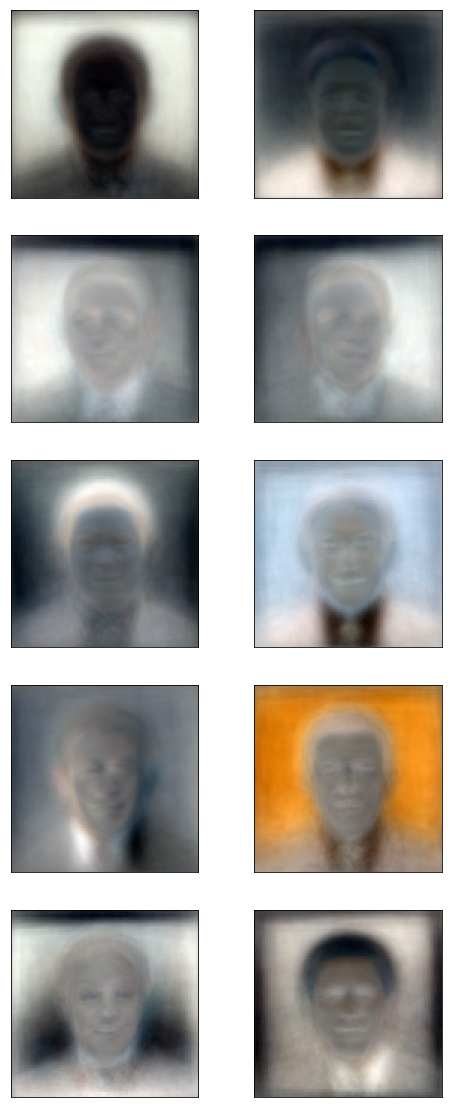

In [17]:
# get the first 10 components
pc_10 = pca.components_[:10].copy()

# normalize them to be in the range 0-1
for i in range(len(pc_10)):
    pc_10[i] = (pc_10[i] - np.min(pc_10[i])) / (np.max(pc_10[i]) - np.min(pc_10[i]))

# plot
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(8,20))
ax = ax.flatten()

for i in range(len(pc_10)):
    ax[i].imshow(pc_10[i].reshape(250,250,3))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show(fig)

### 3.3. Projections, clustering and PCA
 - Project all of the training and test data into the 50-dimensional space defined by the first 50 principal components.
 - Apply k-means clustering, with k=20, to the 50-dimensional projections of the training data. 
 - Display a 4 x 5 grid of images that shows what each of the 20 centroids look like after the centroid is projected back into the original-image space.

> <font color='red'>Project:</font>

In [18]:
pc_50 = pca.components_[:50].copy()
X_train_50 = X_train.dot(pc_50.T)
X_test_50 = X_test.dot(pc_50.T)

> <font color='red'>Cluster, then project the centroids back:</font>

In [19]:
refresh = False

if refresh:
    centroids_train_50, idx_train_50 = ClusterKM(X_train_50, 20)
    np.savetxt('centroids_train_50.txt',centroids_train_50)
    np.savetxt('idx_train_50.txt',idx_train_50)
else:
    centroids_train_50 = np.loadtxt('centroids_train_50.txt')
    idx_train_50 = np.loadtxt('idx_train_50.txt')
    
centroids_train_50 = centroids_train_50.dot(pc_50)

> <font color='red'>Plot:</font>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

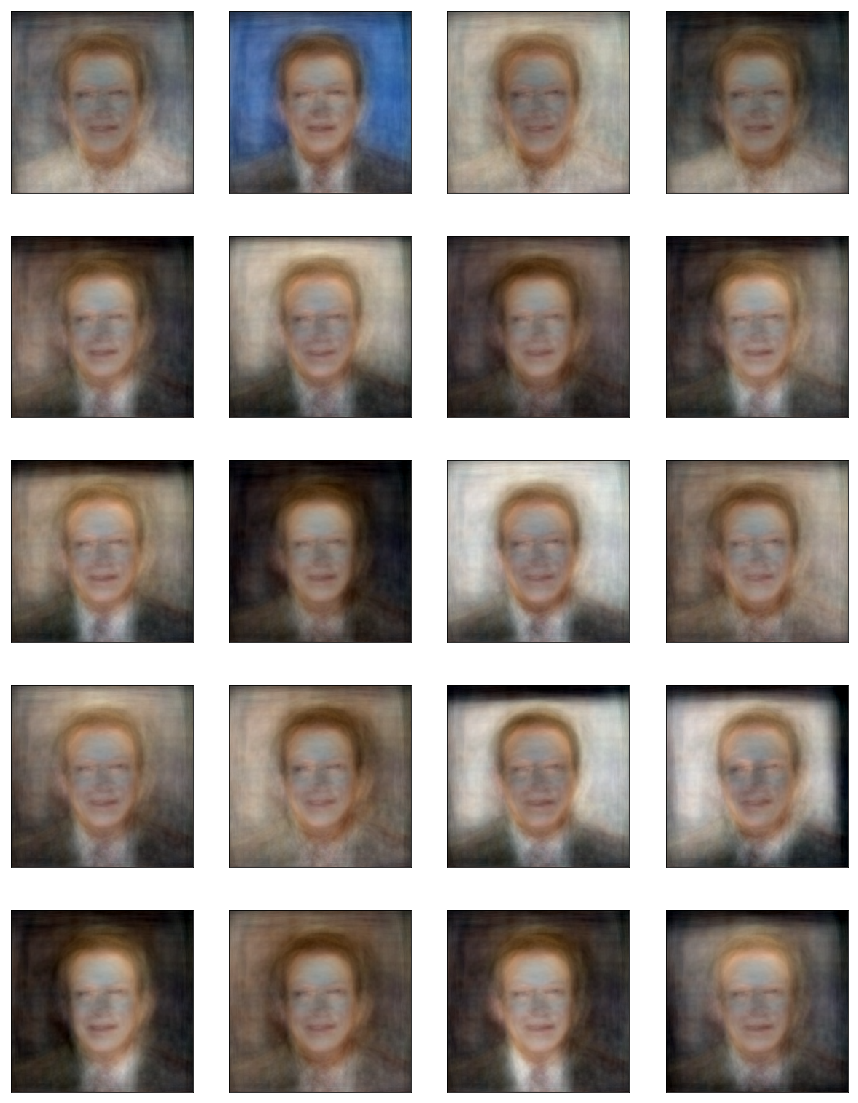

In [20]:
# plot
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,20))
ax = ax.flatten()

for i in range(20):
    ax[i].imshow(centroids_train_50[i].reshape(250, 250, 3))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show(fig)

> <font color='red'>I believe that the cause of the clipping is that the projection (since we are reducing the dimensions to 50) extends the range of the data beyond the original limits of 0-1 for some images.</font>

### 3.4. Recognition

Create a test set of 10 images using (i) 8 images randomly selected from the test data, (ii)  any other non-face image you can find that has the right dimensions, and (iii) an image of yourself. Create a 10 x 5 grid of images, with one row for each of these images, and 5 columns that contain: 
1. The original image. 
2. The reconstruction of that image after it is projected onto the 50-dimensional eigenface-space and then re-projected back into the original image space. 
3. Find the nearest centroid (from 3.3) to the image, and show the reconstruction of that nearest centroid. 
4. Find the image in the training data whose 50-dimensional representation is closest to that centroid, and show the reconstruction of that image.
5. Show the original training image that was selected in above (step 4 in this list)

> <font color='red'>Get the images:</font>

In [21]:
# set up the test images array
test_imgs = np.zeros((10, 187500))

# 8 from the test set
np.random.seed(22)
test_inds = np.random.choice(np.shape(X_test)[0], 8, replace=False)
for i in range(len(test_inds)):
    test_imgs[i] = X_test[test_inds[i]].copy()

# bowls
test_imgs[8] = mpimg.imread('bowls.jpg').reshape((1, 250*250*3))/255

# me
test_imgs[9] = me/255

> <font color='red'>Projection onto the first 50 principal components, then back:</font>

In [22]:
# there
test_imgs_50 = test_imgs.dot(pc_50.T)

# and back again
test_imgs_50 = test_imgs_50.dot(pc_50)

> <font color='red'>Find the closest centroids from part 3.3:</font>

In [23]:
closest_centroids_train_50 = pairwise_distances_argmin(test_imgs_50, centroids_train_50, metric='euclidean')

> <font color='red'>Find the closest neighbours from the reprojected training data from part 3.3:</font>

In [24]:
closest_neighbours_train_50 = pairwise_distances_argmin(centroids_train_50[closest_centroids_train_50],
                                                        X_train_50.dot(pc_50),
                                                        metric='euclidean')

> <font color='red'>Plot:</font>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

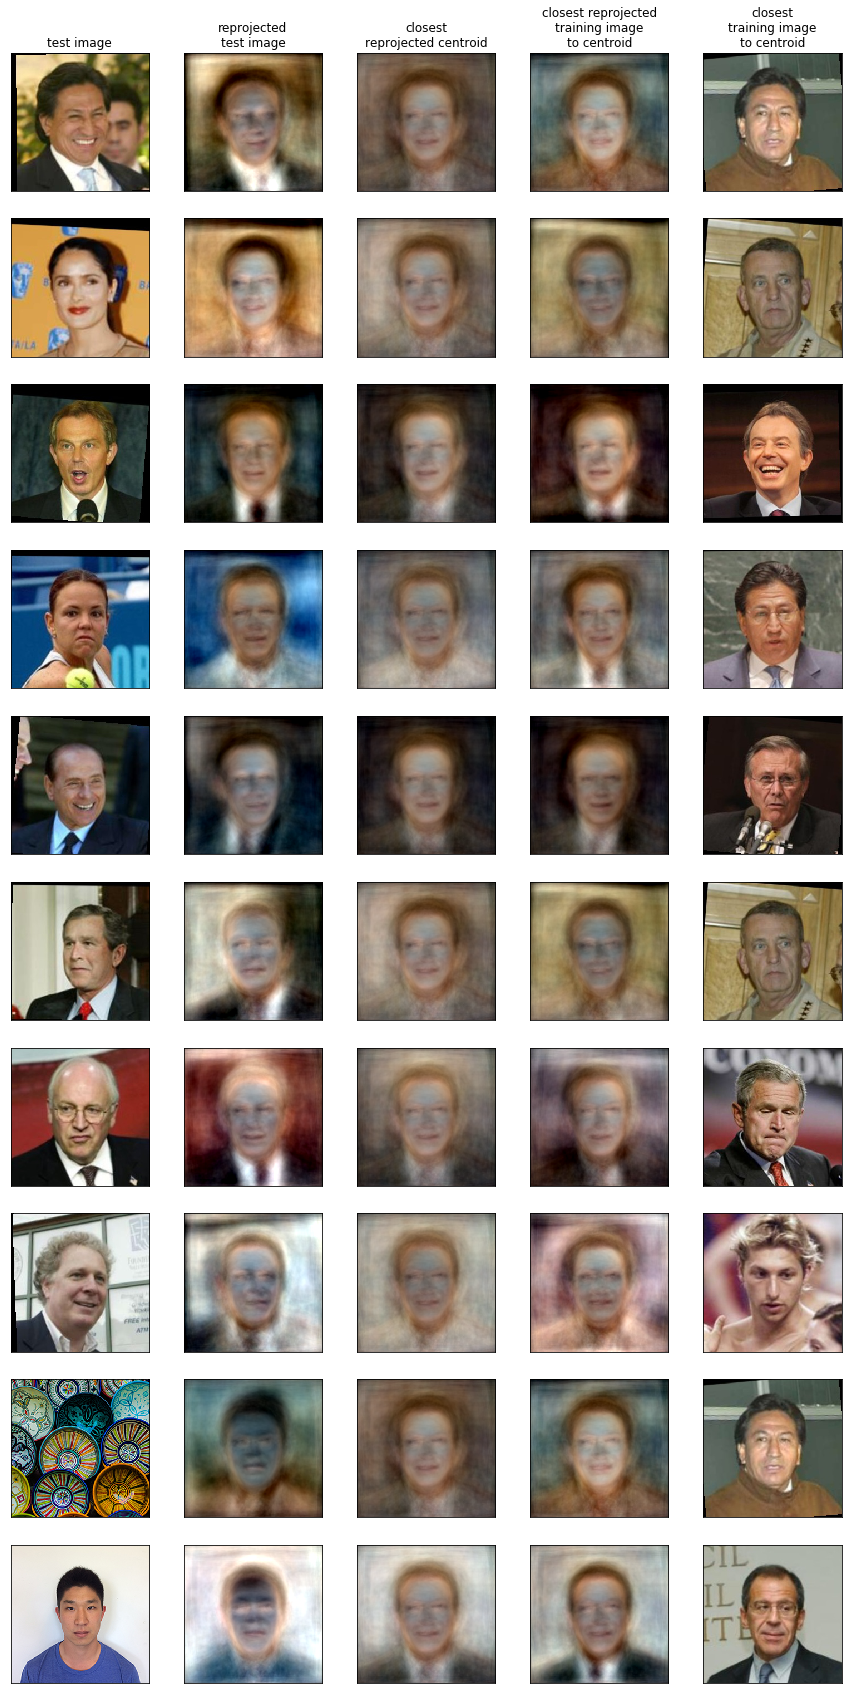

In [25]:
fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(15,30))

for i in range(10):
    ax[i][0].imshow(test_imgs[i].reshape(250, 250, 3))
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    
    ax[i][1].imshow(test_imgs_50[i].reshape(250, 250, 3))
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    
    ax[i][2].imshow(centroids_train_50[closest_centroids_train_50[i]].reshape(250, 250, 3))
    ax[i][2].set_xticks([])
    ax[i][2].set_yticks([])
    
    ax[i][3].imshow(X_train_50.dot(pc_50)[closest_neighbours_train_50[i]].reshape(250, 250, 3))
    ax[i][3].set_xticks([])
    ax[i][3].set_yticks([])
    
    ax[i][4].imshow(X_train[closest_neighbours_train_50[i]].reshape(250, 250, 3))
    ax[i][4].set_xticks([])
    ax[i][4].set_yticks([])
    
ax[0][0].set_title('test image')
ax[0][1].set_title('reprojected\ntest image')
ax[0][2].set_title('closest\nreprojected centroid')
ax[0][3].set_title('closest reprojected\ntraining image\nto centroid')
ax[0][4].set_title('closest\ntraining image\nto centroid')
    
plt.show(fig)

> <font color='red'>Same issues as described above can be seen here: the clustering method is more sensitive to the background than the face itself, so the closest centroids/images are often just a match between the backgrounds.</font>

### 3.5. (Extra credit) Share your results
Post the following to bCourses for people in the class to see:
 - The photo of yourself
 - The cluster centroid from 2.4 that is closest to that image
 - The closest image in the dataset to that cluster centroid
 - The reconstruction of your image after it has been projected and reprojected (i.e., #2 in 3.4)
 - The nearest centroid to the projection (i.e., #3 in 3.4)
 - The closest training image to that centroid (i.e., #5 in 3.4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


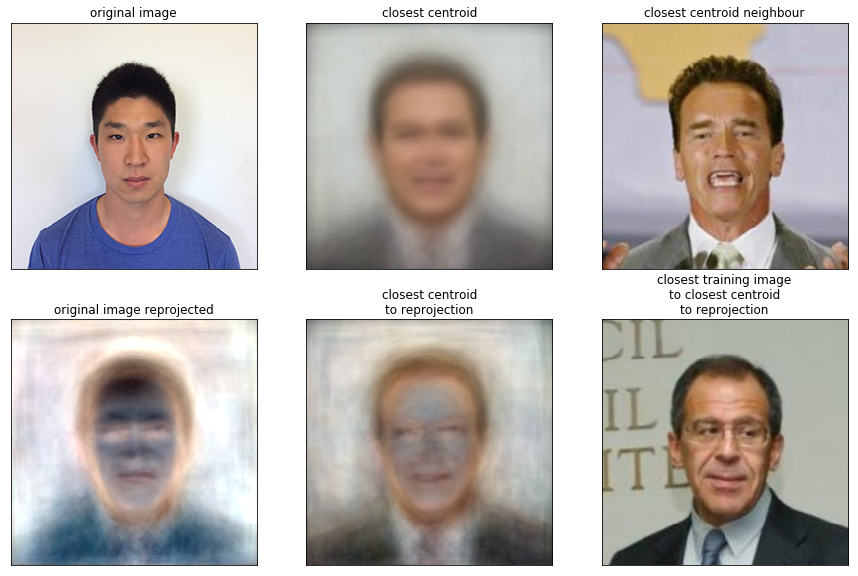

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
ax = ax.flatten()

ax[0].imshow(me.reshape(250, 250, 3))
ax[0].set_title('original image')

ax[1].imshow(centroids[me_closest_centroid[0]].reshape(250,250,3))
ax[1].set_title('closest centroid')

ax[2].imshow(X[closest_neighbours[me_closest_centroid[0]]].reshape(250,250,3))
ax[2].set_title('closest centroid neighbour')

ax[3].imshow(test_imgs_50[9].reshape(250, 250, 3))
ax[3].set_title('original image reprojected')

ax[4].imshow(centroids_train_50[closest_centroids_train_50[9]].reshape(250, 250, 3))
ax[4].set_title('closest centroid\nto reprojection')

ax[5].imshow(X_train[closest_neighbours_train_50[9]].reshape(250, 250, 3))
ax[5].set_title('closest training image\nto closest centroid\nto reprojection')

for i in range(len(ax)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.savefig('part_3_5.jpg', bbox_inches='tight')
plt.show(fig)

### 3.6. (Extra extra credit) PCA Implementation

Implement PCA yourself, without using sklearn. How does the running time of your algorithm compare to the running time of the sklearn version?

> <font color='red'>Sorry.</font>

### 3.6. (Extra extra extra credit): Deep Learning
- Download the latest checkpoint of the pre-trained Inception model from TensorFlow
- Using the pretrained ConvNet, extract features for all of these images
- Redo parts 2.3 (b) and 2.4 (parts 1,3,4) of this problem set using the ConvNet features instead of the raw pixel values
- How do these results compare to the results in parts 2.3 and 2.4? Interpret!

> <font color='red'>Sorry.</font>